In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/ALMPC/examples/Project.toml`
Precompiling project...
  ✓ HTTP
  ✓ GR
  ✓ Plots
  3 dependencies successfully precompiled in 49 seconds (244 already precompiled)


In [2]:
using LinearAlgebra
using Plots 
using SparseArrays
using ForwardDiff
using ControlSystems
using OSQP
using StaticArrays
using Test
using Statistics

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [3]:
# Planar Point Mass Dynamics
function dynamics(x,u)
    ẋ = x[3]
    ẏ = x[4]
    ẍ = -(damp/mass)*ẋ + u[1]/mass 
    ÿ = -(damp/mass)*ẏ + u[2]/mass 
    return [ẋ;ẏ;ẍ;ÿ]
end

dynamics (generic function with 1 method)

In [4]:
# Classic RK4 integration with zero-order hold on u
function dynamics_rk4(f,x,u)
    f1 = f(x, u)
    f2 = f(x + 0.5*h*f1, u)
    f3 = f(x + 0.5*h*f2, u)
    f4 = f(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [5]:
xref = [3.0; 3.0; 0.0; 0.0]   # Reference state [m, m/s]
uref = [0.0; 0.0]        # Reference input [N]
x0 = [0.0; 0.0; 0.0; 0.0]     # Initial state [m, m/s]

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

In [6]:
#Np = 30  # Prediction horizon [s]
h = 0.05 # Time step [s] (20 [Hz])

mass = 2    # Mass [kg]
damp = 0.3  # Damping coefficient [N-s/m]

# Discretized MPC Model dynamics: x_k+1 = Ad*x_k + Bb*u_k
A = [1.0    0.0     h                   0.0             ;
     0.0    1.0     0.0                 h               ;
     0.0    0.0     1-(damp/mass)*h     0.0             ;
     0.0    0.0     0.0                 1-(damp/mass)*h] # State Matrix
B = zeros(4, 2)                # Input Matrix
B[3,1] = (1/mass)*h
B[4,2] = (1/mass)*h

Nx = 4                  # Number of states
Nu = 2                  # Number of controls
Tfinal = 30.0           # Final time [s]
Nt = Int(Tfinal/h)+1    # Number of time steps
thist = Array(range(0,h*(Nt-1), step=h)); # Array of timesteps

#State Constraints
xmin = [-100.0 -100.0]  
xmax = [100.0 100.0]    

#Control Constraints
umin = [-0.5; -0.5]   
umax = [0.5; 0.5]    

# Constraints input variation with respect to previous sample
Dumin = [-2e-1] 
Dumax = [2e-1]

# MPC objective function weights
Q = Array(10.0*I(Nx));
R = Array(.01*I(Nu));
Qn = Array(10.0*I(Nx));

In [7]:
#Cost function
function cost(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end] # Terminal cost
    for k = 1:(size(xhist,2)-1)
        cost += 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1] # State and input cost
    end
    return cost
end

cost (generic function with 1 method)

In [8]:
P = dare(A,B,Q,R)  

4×4 Matrix{Float64}:
 223.253     0.0     19.0143   0.0
   0.0     223.253    0.0     19.0143
  19.0143    0.0     20.1542   0.0
   0.0      19.0143   0.0     20.1542

In [9]:
#Build QP matrices for OSQP
Nh = 40 #one second horizon at 20Hz
U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx)]) #Matrix that picks out all u
H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) P]])
b = zeros(Nh*(Nx+Nu))
C = sparse([[B -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A B]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])

#Dynamics + Thrust limit constraints
D = [C; U]
lb = [zeros(Nx*Nh); kron(ones(Nh),umin)]
ub = [zeros(Nx*Nh); kron(ones(Nh),umax)]

prob = OSQP.Model()
OSQP.setup!(prob; P=H, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);


In [12]:
#MPC Controller
function mpc_controller(t,x,xref)
    #Update QP problem
    lb[1:Nx] .= -A*x
    ub[1:Nx] .= -A*x
    
    for j = 1:(Nh-1)
        b[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref
    end
    b[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref
    
    OSQP.update!(prob, q=b, l=lb, u=ub)

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[1:Nu]
    
    return Δu + uref
end

mpc_controller (generic function with 1 method)

In [13]:
function closed_loop(x0,controller,N)
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    uhist[:,1] .= u0
    xhist[:,1] .= x0
    for k = 1:(N-1)
        uk = controller(k,xhist[:,k])
        uhist[:,k] = max.(min.(umax, uk), umin) #enforce control limits
        xhist[:,k+1] .= dynamics_rk4(dynamics, xhist[:,k],uhist[:,k])
    end
    return xhist, uhist
end

closed_loop (generic function with 1 method)

In [14]:
xhist1, uhist1 = closed_loop(x0, (t,x)->mpc_controller(t,x,xref), Nt)

([0.0 0.00031172021484375 … 2.9999999999852958 2.9999999999859956; 0.0 0.00031172021484375 … 2.9999999999852958 2.9999999999859956; 0.0 0.012453241967773435 … 1.4340646553635907e-11 1.3657901711081677e-11; 0.0 0.012453241967773435 … 1.434040099801105e-11 1.3657846665386542e-11], [0.5 0.5 … -2.4277550096854617e-11 -2.3110139477724134e-11; 0.5 0.5 … -2.428228569961526e-11 -2.310256413501246e-11])

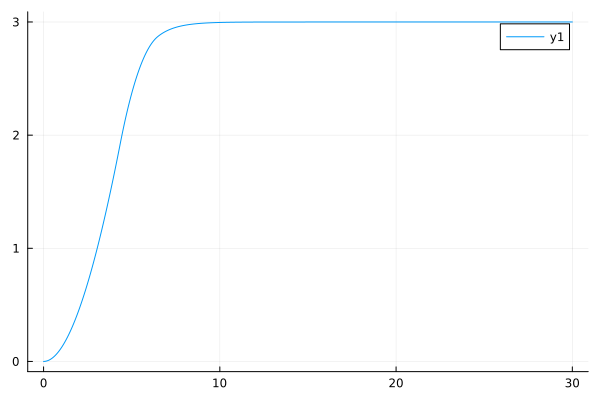

In [15]:
# x position
plot(thist, xhist1[1,:]) 

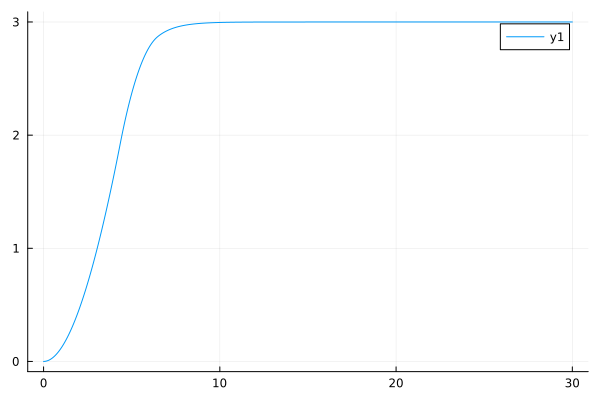

In [16]:
# y position
plot(thist, xhist1[2,:])

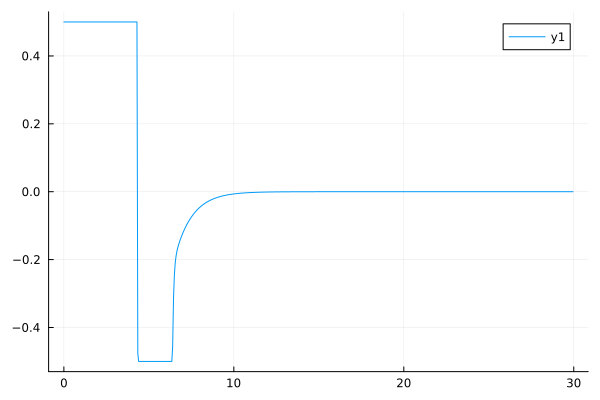

In [17]:
# x Force
plot(thist[1:length(thist)-1], uhist1[1,:])

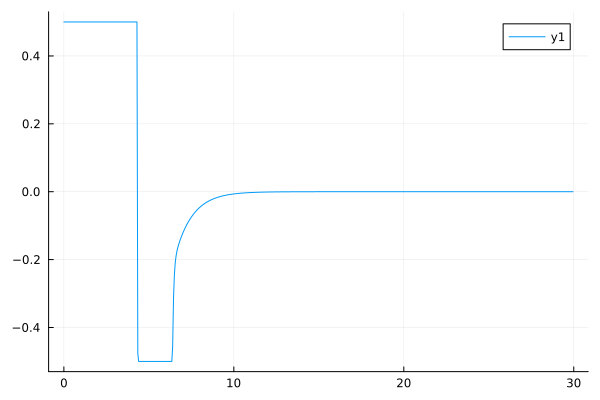

In [18]:
# y Force
plot(thist[1:length(thist)-1], uhist1[2,:])

┌ Info: Saved animation to /home/ahmed/.julia/dev/ALMPC/examples/state_ref_MPC.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/ALMPC/examples/state_ref_MPC.gif")
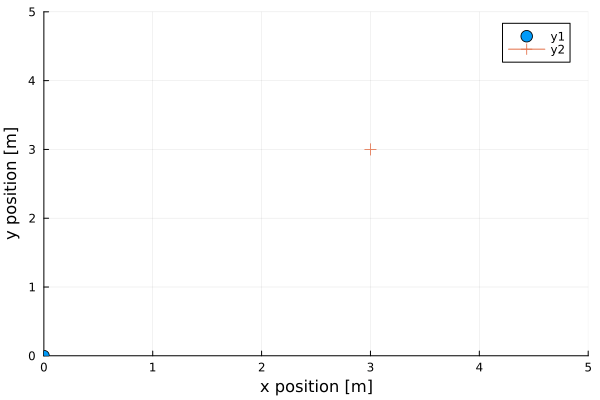

In [19]:
anim = @animate for i in 1:length(xhist1[1,:])
    # plot([xref[1]*ones(size(thist))],
    #     xlims = (0, 20), 
    #     ylims = (0, 10), 
    #     aspect_ratio = 1,
    #     linestyle =:dash,
    #     legend = false)
    # plot!(thist, xhist1[1,:])
    scatter([xhist1[1,i]],
            [xhist1[2,i]], 
            m = (:circle, 6), 
            xlims = (0, 5),
            ylims = (0, 5),
            xlabel = "x position [m]",
            ylabel = "y position [m]")

    plot!([xref[1]], [xref[2]], m = (:cross, 6))
end every 10;
gif(anim, "state_ref_MPC.gif")